<a href="https://colab.research.google.com/github/neetinds/Stock-Price-Prediction/blob/main/Stock_Price_Prediction_Using_LSTM_%26_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Stock Price Prediction Using LSTM & ARIMA**





## **1. Stock Price Predicting with LSTM**

Neural Networks have been demonstrated to be very powerful in solving the real-world problems like imaging and natural language processing. Interested in stock price movements, I am therefore motivated and curious about employing nerual nets to approach financial time series problems of its kind.

Unlike common regression predictions, time series problems are more difficult due to sequence dependence within the input data variables. Among various neural nets, Long Short-Term Memory (LSTM), a type of recurrent neural network, has been proven to take care of complex time series predictions. So I implement LSTM to Amazon's stock prices (AMZN)

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import preprocessing
import pandas_datareader as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import math

Mount my GDRIVE

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 1.1 Load Data
# LSTM Modeling For AMAZON Stock Price
Get up to five-year daily historical stock prices & volumes data from https://finance.yahoo.com/quote/AMZN/history?p=AMZN.

Datasets consist of following columns:


*   **Date Time** stamp of when data was collected, being used as index column;

*   **Volume** The number of shares traded in AMZN during a given trading day;



*   **Open** The price at AMZN upon the opening of an exchange on a given trading day


*   **High** The highest price at which AMZN traded during the course of the day

*   **Low** The lowest price at which AMZN traded during the course of the day;


*   **Close** The final price at which AMZN traded during the course of the day; it is also selected as our target data.

In [5]:
data = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/AMZN.csv')


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2518 entries, 0 to 2517
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2518 non-null   object 
 1   Open       2518 non-null   float64
 2   High       2518 non-null   float64
 3   Low        2518 non-null   float64
 4   Close      2518 non-null   float64
 5   Adj Close  2518 non-null   float64
 6   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 137.8+ KB


In [7]:
#Change the date foramt and set it as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date',inplace=True)

In [8]:
data.shape

(2518, 6)

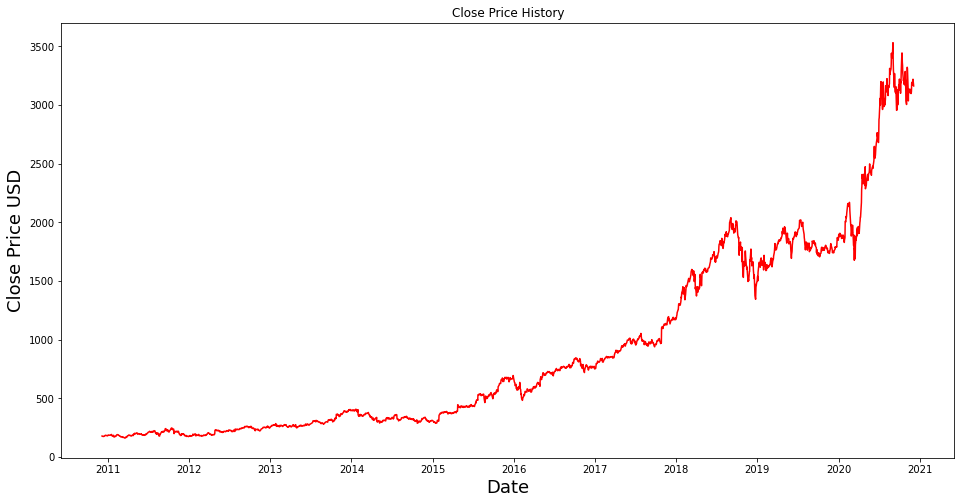

In [9]:
#plotting the data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data['Close'], color='red')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

The next step is to split the data into training and test sets to avoid overfitting and to be able to investigate the generalization ability of our model. 

In [10]:
# Create a new data frame with only 'Close column'
data = data.filter(['Close'])
dataset = data.values #convert the data frame to a numpy array
training_data_len = math.ceil(len(dataset)*.7)  # number of rows to train the model on
training_data_len

1763

**Scale the data**




In [11]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.00506753],
       [0.00468776],
       [0.00454534],
       ...,
       [0.90270824],
       [0.89772377],
       [0.89055865]])

# **Create the training dataset, scaled training dataset**

In [12]:
train_data = scaled_data[0:training_data_len, :]
#Split the data into x_train, y_train datasets
x_train = []
y_train = []
for i in range(60,len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i,0])
    if i<=60:
        print(x_train)
        print(y_train)
        print()

[array([0.00506753, 0.00468776, 0.00454534, 0.00411811, 0.00434656,
       0.00394009, 0.00384812, 0.00433173, 0.00506456, 0.00492808,
       0.0066222 , 0.00705537, 0.00705834, 0.00641452, 0.006281  ,
       0.00596947, 0.00664594, 0.00646199, 0.00564608, 0.00689813,
       0.00713251, 0.00784755, 0.0073847 , 0.00727493, 0.0070346 ,
       0.00693373, 0.00685659, 0.0072868 , 0.00824215, 0.00898388,
       0.00768436, 0.0062276 , 0.00488061, 0.0047115 , 0.00466699,
       0.00427832, 0.00696637, 0.00301737, 0.00257233, 0.00330517,
       0.00372647, 0.00377988, 0.00443853, 0.00458688, 0.00655396,
       0.00721856, 0.00748855, 0.0083905 , 0.00873763, 0.00832522,
       0.00761019, 0.00794842, 0.00757459, 0.00577069, 0.00466105,
       0.00497852, 0.00482721, 0.00365526, 0.002513  , 0.00327847])]
[0.0035069165742997455]



In [13]:
#convert the x_train and y_train  to numppy array
x_train,y_train = np.array(x_train), np.array(y_train)

In [14]:
#reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1703, 60, 1)

In [15]:
#Buil the LSTM model
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))

In [16]:
#Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
#Train the model
model.fit(x_train,y_train, batch_size=1, epochs=10)

Epoch 1/10
1703/1703 [==============================] - 58s 24ms/step - loss: 3.5829e-04
Epoch 2/10
1703/1703 [==============================] - 40s 24ms/step - loss: 7.1320e-05
Epoch 3/10
1703/1703 [==============================] - 40s 24ms/step - loss: 5.1347e-05
Epoch 4/10
1703/1703 [==============================] - 40s 23ms/step - loss: 6.2551e-05
Epoch 5/10
1703/1703 [==============================] - 39s 23ms/step - loss: 3.0327e-05
Epoch 6/10
1703/1703 [==============================] - 40s 23ms/step - loss: 2.5827e-05
Epoch 7/10
1703/1703 [==============================] - 40s 23ms/step - loss: 3.0713e-05
Epoch 8/10
1703/1703 [==============================] - 40s 24ms/step - loss: 3.3055e-05
Epoch 9/10
1703/1703 [==============================] - 40s 23ms/step - loss: 3.2677e-05
Epoch 10/10
1703/1703 [==============================] - 42s 24ms/step - loss: 3.1315e-05


In [18]:
#create the testing data sets
#create a new array containing scale values from index 1763 to 2518
test_data= scaled_data[training_data_len-60:, :]
#create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60,len(test_data)):
    x_test.append(test_data[i-60:i,0])

In [20]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [21]:
y_test.shape

(755, 1)

In [22]:
#reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
x_test.shape

(755, 60, 1)

In [23]:
#predicting the data
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [24]:
predictions.shape

(755, 1)

In [25]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

27.198338724679218

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


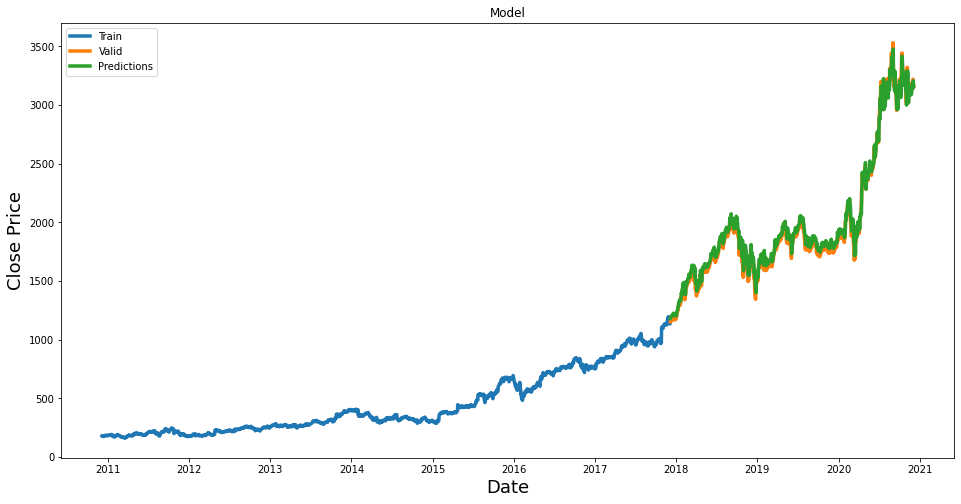

In [26]:
#plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#Visialization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=3.5)
plt.plot(valid[['Close','Predictions']],linewidth=3.5)
plt.legend(['Train','Valid','Predictions'])

In [27]:
#show the valid and predicted price
valid

,Close,Predictions
Date,,
2017-12-06,1152.349976,1180.535889
2017-12-07,1159.790039,1190.031006
2017-12-08,1162.000000,1196.109253
2017-12-11,1168.920044,1197.122437
2017-12-12,1165.079956,1204.060181
...,...,...
2020-11-30,3168.040039,3171.243408
2020-12-01,3220.080078,3141.889893
2020-12-02,3203.530029,3206.718262


In [28]:
#get the quote
amzn_quote = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/AMZN.csv')
#Create new data frame
new_df = amzn_quote.filter(['Close'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scaled the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#create an empty list
X_test = []
#append the past 60 days 
X_test.append(last_60_days_scaled)
#convert the X_test data set to a numpy array
X_test = np.array(X_test)
#Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0], X_test.shape[1],1))
#get the predicted scaled price
pred_price= model.predict(X_test)
#undo the scalling
pred_price = scaler.inverse_transform(pred_price)
pred_price

array([[3142.0105]], dtype=float32)

# Accuracy Score - AMAZON LSTM Prediction

In [29]:
# Measure the Accuracy Score
Acc = []
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test, predictions)))
Acc.append(r2_score(y_test, predictions))

Accuracy score of the predictions: 0.989736026487859




---



---



# 1.2 LSTM Modeling For Google Stock

In [46]:
data_G = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/GOOG.csv')

In [47]:
data_G.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2752 entries, 0 to 2751
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2752 non-null   object 
 1   Open       2752 non-null   float64
 2   High       2752 non-null   float64
 3   Low        2752 non-null   float64
 4   Close      2752 non-null   float64
 5   Adj Close  2752 non-null   float64
 6   Volume     2752 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 150.6+ KB


In [48]:
#Change the date foramt and set it as index
#dtype.data_G['Date']
data_G['Date'] = pd.to_datetime(data_G['Date'])
data_G.set_index('Date',inplace=True)
data_G.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2752 entries, 2010-01-04 to 2020-12-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2752 non-null   float64
 1   High       2752 non-null   float64
 2   Low        2752 non-null   float64
 3   Close      2752 non-null   float64
 4   Adj Close  2752 non-null   float64
 5   Volume     2752 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 150.5 KB


In [49]:
data_G.shape

(2752, 6)

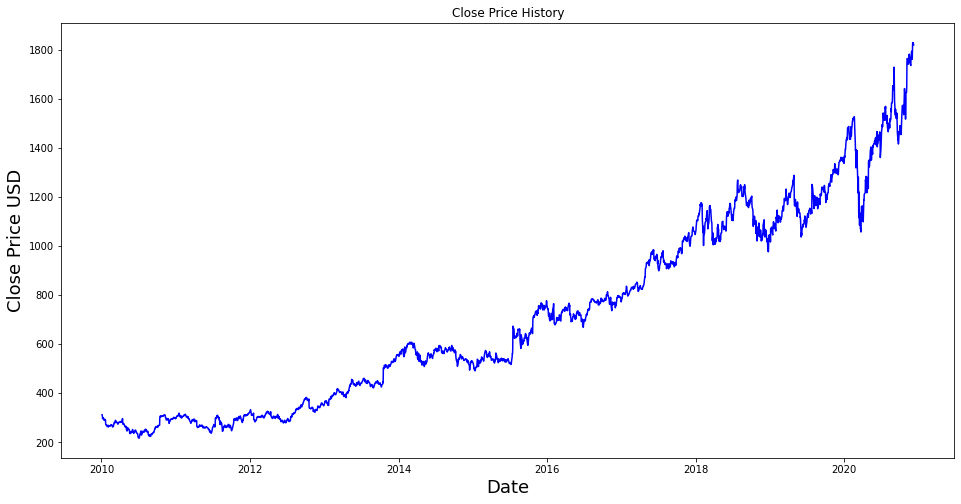

In [50]:
#plotting the data
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(data_G['Close'], color='blue')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD', fontsize = 18)
plt.show()

In [51]:
# Create a new data frame with only 'Close column'
data_G = data_G.filter(['Close'])
dataset_G = data_G.values #convert the data frame to a numpy array
training_data_len_G = math.ceil(len(dataset_G)*.7)  # number of rows to train the model on
training_data_len_G

1927

In [52]:
#Scale the data
scaler_G = MinMaxScaler(feature_range=(0,1))
scaled_data_G = scaler_G.fit_transform(dataset_G)
scaled_data_G

array([[0.05896808],
       [0.05811454],
       [0.05325002],
       ...,
       [0.99924262],
       [1.        ],
       [0.9947168 ]])

In [53]:
train_data_G = scaled_data_G[0:training_data_len_G, :]
#Split the data into x_train, y_train datasets
x_train_G = []
y_train_G = []
for i in range(60,len(train_data_G)):
    x_train_G.append(train_data_G[i-60:i, 0])
    y_train_G.append(train_data_G[i,0])
    if i<=60:
        print(x_train_G)
        print(y_train_G)
        print()

[array([0.05896808, 0.05811454, 0.05325002, 0.04887102, 0.05132029,
       0.05103887, 0.04775154, 0.04670316, 0.0475567 , 0.04451056,
       0.04686706, 0.04463737, 0.04543213, 0.03523611, 0.03214051,
       0.0328889 , 0.03278994, 0.03037467, 0.02902944, 0.02998193,
       0.02939435, 0.03239409, 0.0280522 , 0.02944693, 0.0301211 ,
       0.03103958, 0.03042416, 0.03102721, 0.03001286, 0.03254253,
       0.03158695, 0.0331363 , 0.03237554, 0.03300642, 0.03061589,
       0.02950259, 0.02794396, 0.0280584 , 0.02987988, 0.03246832,
       0.03378573, 0.0366525 , 0.03962749, 0.03909249, 0.03838429,
       0.04341272, 0.04486311, 0.04436832, 0.03930897, 0.03993365,
       0.04004498, 0.04030475, 0.03832554, 0.03755241, 0.03492377,
       0.03749984, 0.03921619, 0.03915744, 0.03908321, 0.04040061])]
[0.04052741994976586]



In [54]:
#convert the x_train_G and y_train_G  to numppy array
x_train_G,y_train_G = np.array(x_train_G), np.array(y_train_G)

In [55]:
#reshape the data
x_train_G = np.reshape(x_train_G,(x_train_G.shape[0],x_train_G.shape[1],1))
x_train_G.shape

(1867, 60, 1)

In [56]:
#BuilD the LSTM model
model =Sequential()
model.add(LSTM(64,return_sequences=True, input_shape=(x_train_G.shape[1],1)))
model.add(LSTM(64, return_sequences= False))
model.add(Dense(32))
model.add(Dense(1))


In [57]:

#Complie the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [58]:
#Train the model
model.fit(x_train_G,y_train_G, batch_size=1, epochs=10)


Epoch 1/10
1867/1867 [==============================] - 47s 24ms/step - loss: 6.8833e-04
Epoch 2/10
1867/1867 [==============================] - 44s 23ms/step - loss: 1.7279e-04
Epoch 3/10
1867/1867 [==============================] - 46s 25ms/step - loss: 1.2227e-04
Epoch 4/10
1867/1867 [==============================] - 44s 24ms/step - loss: 1.3040e-04
Epoch 5/10
1867/1867 [==============================] - 44s 24ms/step - loss: 8.3214e-05
Epoch 6/10
1867/1867 [==============================] - 44s 24ms/step - loss: 8.1420e-05
Epoch 7/10
1867/1867 [==============================] - 44s 24ms/step - loss: 6.9770e-05
Epoch 8/10
1867/1867 [==============================] - 44s 24ms/step - loss: 6.6640e-05
Epoch 9/10
1867/1867 [==============================] - 44s 24ms/step - loss: 6.9495e-05
Epoch 10/10
1867/1867 [==============================] - 43s 23ms/step - loss: 4.9899e-05


In [79]:
#create the testing data sets
test_data_G= scaled_data_G[training_data_len_G-60:, :]

#create the data sets x_test_G and y_test_G
x_test_G = []
y_test_G = dataset_G[training_data_len_G:,:]
for i in range(60,len(test_data_G)):
    x_test_G.append(test_data_G[i-60:i,0])

In [80]:
y_test_G.shape

(825, 1)

In [81]:
#convert the data to a numpy array
x_test_G = np.array(x_test_G)
#y_test_G = np.array(y_test_G)

#reshape the data
x_test_G = np.reshape(x_test_G, (x_test_G.shape[0], x_test_G.shape[1],1))
x_test_G.shape

(825, 60, 1)

In [82]:
#predicting the data
predictions_G = model.predict(x_test_G)
predictions_G = scaler_G.inverse_transform(predictions_G)

In [83]:
predictions_G.shape

(825, 1)

In [84]:
#get the root mean square error(RMSE)
rmse = np.sqrt(np.mean(predictions_G - y_test_G)**2)
rmse

29.617026592125942

In [129]:
print(training_data_len_G)

1927


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


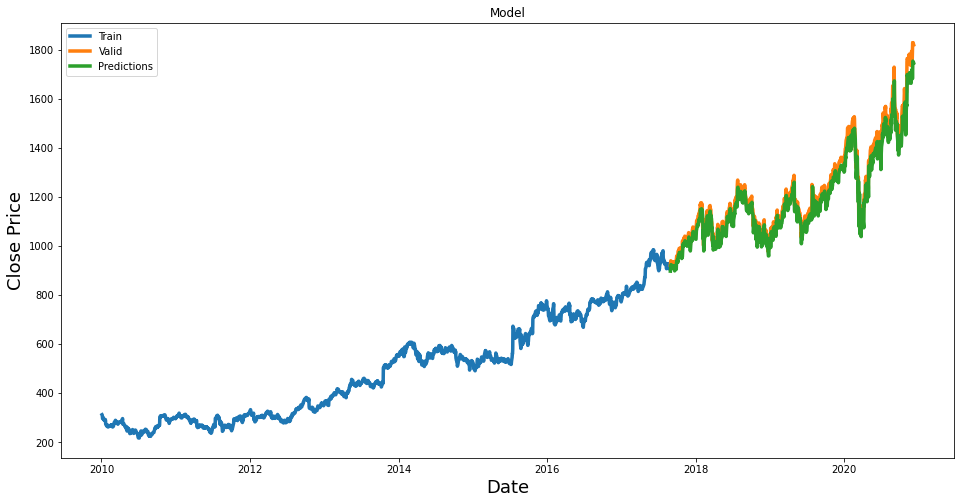

In [85]:
#plot the data
train = data_G[:training_data_len_G]
valid = data_G[training_data_len_G:]
valid['Predictions'] = predictions_G
#Visialization the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price' ,fontsize=18)
plt.plot(train['Close'],linewidth=3.5)
plt.plot(valid[['Close','Predictions']],linewidth=3.5)
plt.legend(['Train','Valid','Predictions'])

In [86]:
#show the valid and predicted price
valid

,Close,Predictions
Date,,
2017-08-29,921.289978,897.207458
2017-08-30,929.570007,905.766968
2017-08-31,939.330017,914.047302
2017-09-01,937.340027,923.658875
2017-09-05,928.450012,920.111633
...,...,...
2020-12-01,1798.099976,1680.980957
2020-12-02,1827.949951,1726.870972
2020-12-03,1826.770020,1752.894043


In [87]:
#get the quote
goog_quote = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/GOOG.csv')
#Create new data frame
new_df = goog_quote.filter(['Close'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scaled the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#create an empty list
X_test_G = []
#append the past 60 days 
X_test_G.append(last_60_days_scaled)
#convert the X_test data set to a numpy array
X_test_G = np.array(X_test_G)
#Reshape the data
X_test_G = np.reshape(X_test_G,(X_test_G.shape[0], X_test_G.shape[1],1))
#get the predicted scaled price
pred_price_G= model.predict(X_test_G)
#undo the scalling
pred_price_G = scaler_G.inverse_transform(pred_price_G)
pred_price_G


array([[990.24835]], dtype=float32)

#  Accuracy Score - GOOGLE LSTM Prediction 

In [88]:
# Measure the Accuracy Score
Acc_G = []
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(y_test_G, predictions_G)))
Acc_G.append(r2_score(y_test_G, predictions_G))

Accuracy score of the predictions: 0.957041764999876


# 2. Stock Price Predicting with - The AutoRegressive Integrated Moving Average (ARIMA) model

Time-series & forecasting models Time-series forecasting models are the models that are capable to predict future values based on previously observed values. Time-series forecasting is widely used for non-stationary data. Non-stationary data are called the data whose statistical properties e.g. the mean and standard deviation are not constant over time but instead, these metrics vary over time. These non-stationary input data (used as input to these models) are usually called time-series. Some examples of time-series include the temperature values over time, stock price over time, price of a house over time etc. So, the input is a signal (time-series) that is defined by observations taken sequentially in time.A time series is a sequence of observations taken sequentially in time.



*   AR: < Auto Regressive > means that the model uses the dependent relationship 
between an observation and some predefined number of lagged observations (also known as “time lag” or “lag”).


*   I:< Integrated > means that the model employs differencing of raw observations (e.g. it subtracts an observation from an observation at the previous time step) in order to make the time-series stationary


*   MA: < Moving Average > means that the model exploits the relationship between the residual error and the observations.
Model parameters

The standard ARIMA models expect as input parameters 3 arguments i.e. p,d,q. p is the number of lag observations. d is the degree of differencing. q is the size/width of the moving average window.

# 2.1 Amazon Stock Price Prediction 

In [89]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [90]:
Adata = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/AMZN.csv')
Adata['Date'] = pd.to_datetime(Adata['Date'])
Adata.set_index('Date',inplace=True)

In [91]:
Adata.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2518 entries, 2010-12-06 to 2020-12-04
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2518 non-null   float64
 1   High       2518 non-null   float64
 2   Low        2518 non-null   float64
 3   Close      2518 non-null   float64
 4   Adj Close  2518 non-null   float64
 5   Volume     2518 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 137.7 KB


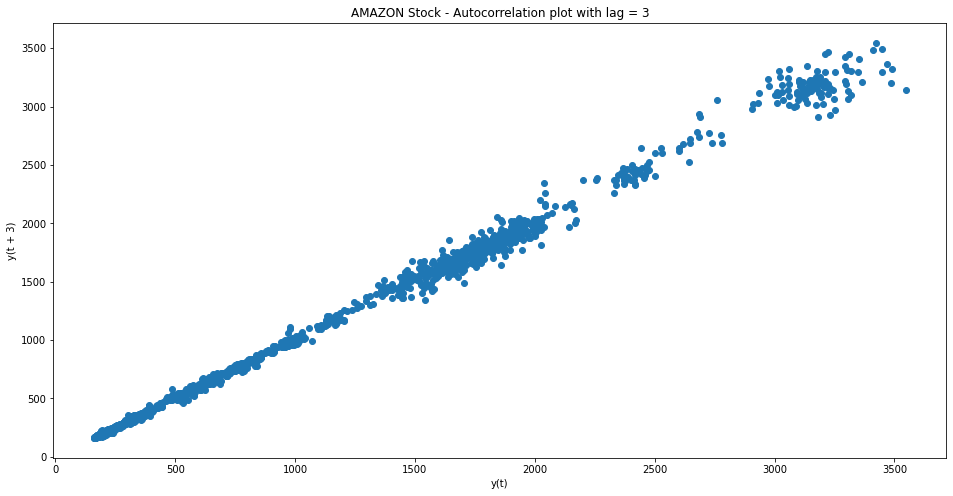

In [92]:
#Our target variable will be the Close value.
#Before building the ARIMA model, let’s see if there is some cross-correlation in our data.
plt.figure(figsize=(16,8))
lag_plot(Adata['Open'], lag=3)
plt.title('AMAZON Stock - Autocorrelation plot with lag = 3')
plt.show()


We can now confirm that ARIMA is going to be a good model to be applied to this type of data (there is auto-correlation in the data).

Finally, let’s plot the stock price evolution over time.

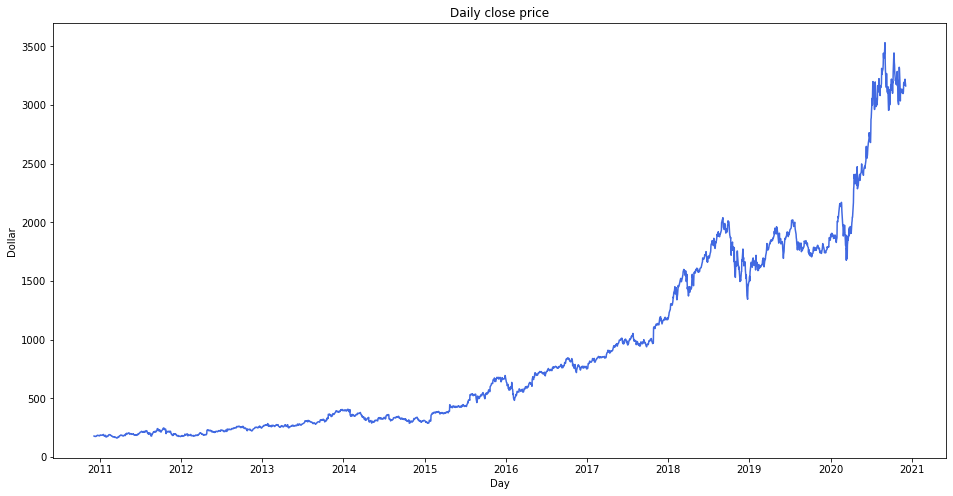

In [93]:
plt.figure(figsize=(16,8))
plt.plot(Adata.index, Adata['Close'], color='royalblue')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

Build the predictive ARIMA model

Next, let’s divide the data into a training (70 % ) and test (30%) set. For this tutorial we select the following ARIMA parameters: p=4, d=1 and q=0.

In [94]:
train_data, test_data = Adata[0:int(len(Adata)*0.7)], Adata[int(len(Adata)*0.7):]
training_data = train_data['Close'].values
test_data = test_data['Close'].values
history = [x for x in training_data]
model_predictions = []
N_test_observations = len(test_data)
for time_point in range(N_test_observations):
    model = ARIMA(history, order=(4,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = test_data[time_point]
    history.append(true_test_value)
MSE_error = mean_squared_error(test_data, model_predictions)
print('Testing Mean Squared Error is {}'.format(MSE_error))

Testing Mean Squared Error is 1977.6938758025142


Summary of the code We split the training dataset into train and test sets and we use the train set to fit the model, and generate a prediction for each element on the test set. A rolling forecasting procedure is required given the dependence on observations in prior time steps for differencing and the AR model. To this end, we re-create the ARIMA model after each new observation is received. Finally, we manually keep track of all observations in a list called history that is seeded with the training data and to which new observations are appended at each iteration. Testing Mean Squared Error is **1977.6938758025142**

The MSE of the test set is quite large denoting that the precise prediction is a hard problem. However, this is the average squared value across all the test set predictions. Let’s visualize the predictions to understand the performance of the model more.

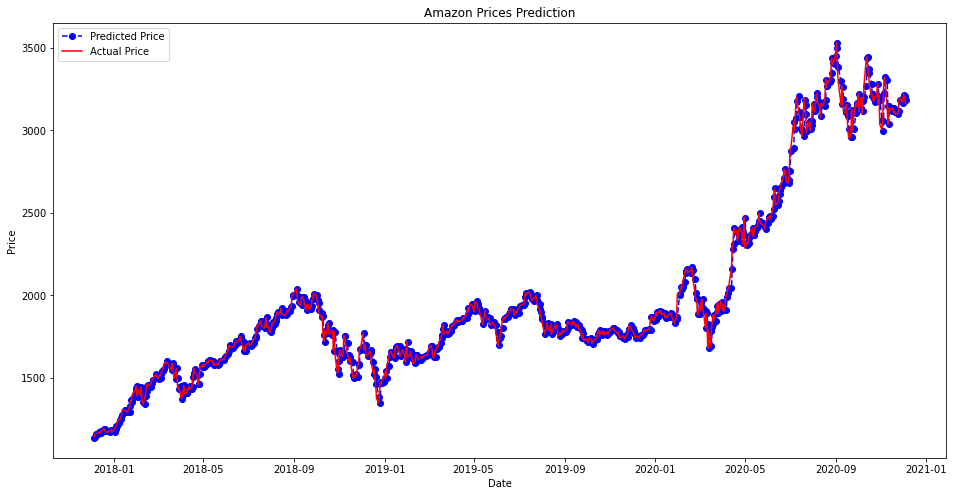

In [95]:
test_set_range = Adata[int(len(Adata)*0.7):].index
plt.figure(figsize=(16,8))
plt.plot(test_set_range, model_predictions, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range, test_data, color='red', label='Actual Price')
plt.title('Amazon Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [143]:
#Get records from dataframe to plot VALID tabular comparison of Close Prediction
Adata = Adata.filter(['Close'])
Adataset = Adata.values #convert the data frame to a numpy array
Atraining_data_len = math.ceil(len(Adataset)*.7)  # number of rows to train the model on
Atraining_data_len

1763

In [145]:
#Plot the Close & Prediction values
train = Adata[:Atraining_data_len]
valid = Adata[Atraining_data_len - 1:]
model_predictions = np.array(model_predictions)
valid['Predictions'] = model_predictions
#Visialization the datamodel_predictions.shape
valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Close,Predictions
Date,,
2017-12-05,1141.569946,1134.937334
2017-12-06,1152.349976,1142.708562
2017-12-07,1159.790039,1154.893957
2017-12-08,1162.000000,1161.372195
2017-12-11,1168.920044,1161.691395
...,...,...
2020-11-30,3168.040039,3195.327823
2020-12-01,3220.080078,3164.858146
2020-12-02,3203.530029,3217.185273


# Accuracy score  - Amazon ARIMA prediction

In [99]:

from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(test_data, model_predictions)))
Acc.append(r2_score(test_data, model_predictions))

Accuracy score of the predictions: 0.9936222183900572


# 2.2 Google Stock Price Prediction Using ARIMA

In [100]:
Adata_G = pd.read_csv('/content/gdrive/MyDrive/Stock-Price-Prediction-main/Time Series - Stock Price Prediction/GOOG.csv')
Adata_G['Date'] = pd.to_datetime(Adata_G['Date'])
Adata_G.set_index('Date',inplace=True)


In [101]:
Adata_G.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2752 entries, 2010-01-04 to 2020-12-07
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2752 non-null   float64
 1   High       2752 non-null   float64
 2   Low        2752 non-null   float64
 3   Close      2752 non-null   float64
 4   Adj Close  2752 non-null   float64
 5   Volume     2752 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 150.5 KB


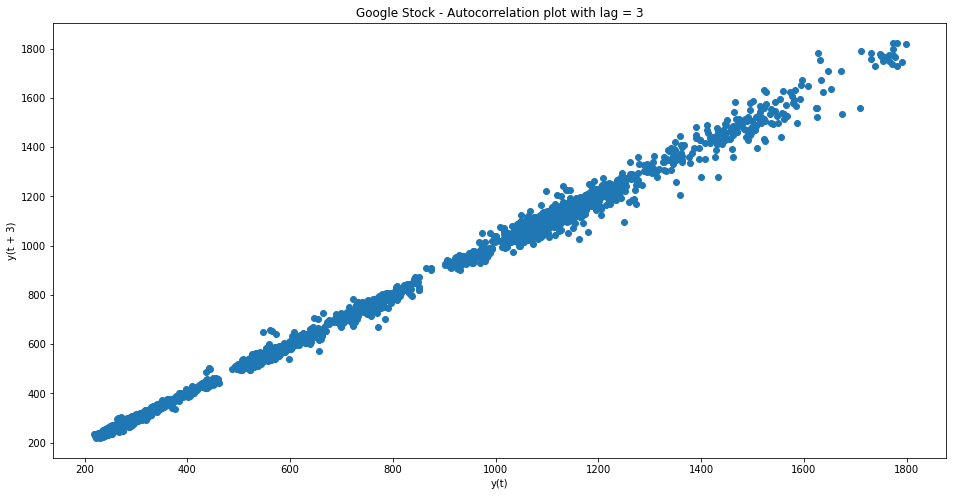

In [102]:
#Our target variable will be the Close value.
#Before building the ARIMA model, let’s see if there is some cross-correlation in our data.
plt.figure(figsize=(16,8))
lag_plot(Adata_G['Open'], lag=3)
plt.title('Google Stock - Autocorrelation plot with lag = 3')
plt.show()


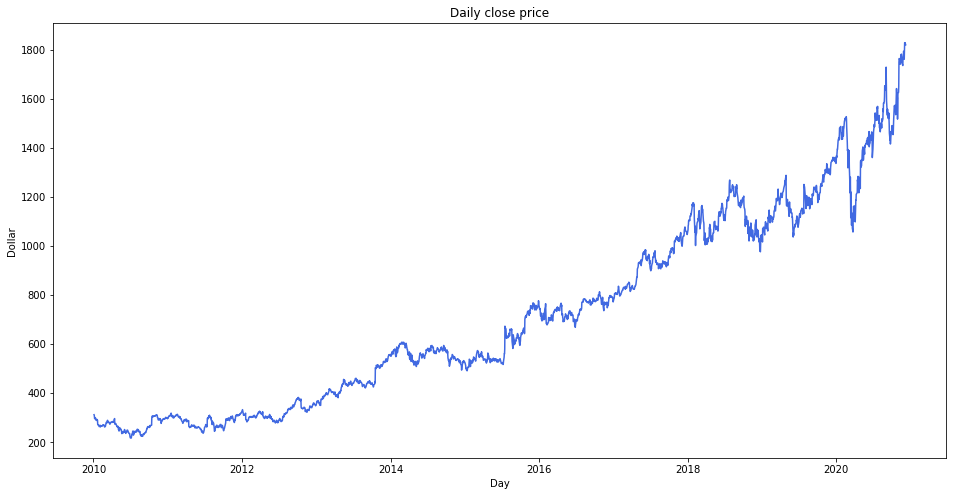

In [103]:
plt.figure(figsize=(16,8))
plt.plot(Adata_G.index, Adata_G['Close'], color='royalblue')
plt.title('Daily close price')
plt.xlabel('Day')
plt.ylabel('Dollar')
plt.show()

In [104]:
train_data_G, test_data_G = Adata_G[0:int(len(Adata_G)*0.7)], Adata_G[int(len(Adata_G)*0.7):]
training_data_G = train_data_G['Close'].values
test_data_G = test_data_G['Close'].values
history_G = [x for x in training_data_G]
model_predictions_G = []
N_test_observations_G = len(test_data_G)
for time_point in range(N_test_observations_G):
    model = ARIMA(history_G, order=(4,1,0))
    model_fit_G = model.fit(disp=0)
    output = model_fit_G.forecast()
    yhat = output[0]
    model_predictions_G.append(yhat)
    true_test_value_G= test_data_G[time_point]
    history_G.append(true_test_value_G)
MSE_error= mean_squared_error(test_data_G, model_predictions_G)
print('Testing Mean Squared Error is {}'.format(MSE_error))


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Testing Mean Squared Error is 537.6466806589963


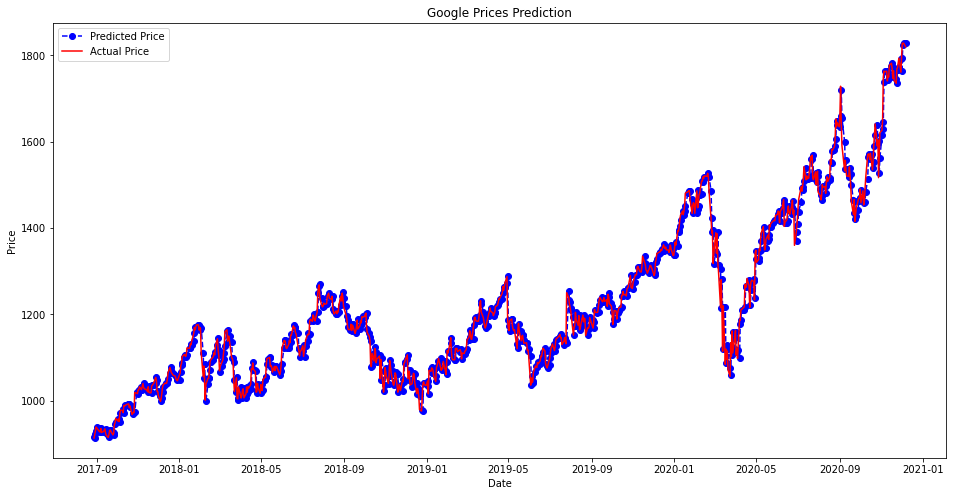

In [105]:
test_set_range_G = Adata_G[int(len(Adata_G)*0.7):].index
plt.figure(figsize=(16,8))
plt.plot(test_set_range_G, model_predictions_G, color='blue', marker='o', linestyle='dashed',label='Predicted Price')
plt.plot(test_set_range_G, test_data_G, color='red', label='Actual Price')
plt.title('Google Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [146]:
#Get records from dataframe to plot VALID tabular comparison of Close Prediction
Adata_G = Adata_G.filter(['Close'])
Adataset_G = Adata_G.values #convert the data frame to a numpy array
Atraining_data_len_G = math.ceil(len(Adataset_G)*.7)  # number of rows to train the model on
Atraining_data_len_G

1927

In [148]:
#Plot the Close & Prediction values
train = Adata_G[:Atraining_data_len_G]
valid = Adata_G[Atraining_data_len_G - 1:]
model_predictions_G = np.array(model_predictions_G)
valid['Predictions'] = model_predictions_G
#Visialization the datamodel_predictions.shape
valid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Close,Predictions
Date,,
2017-08-28,913.809998,915.612122
2017-08-29,921.289978,914.205372
2017-08-30,929.570007,922.101908
2017-08-31,939.330017,930.372567
2017-09-01,937.340027,939.748759
...,...,...
2020-12-01,1798.099976,1764.306477
2020-12-02,1827.949951,1794.222022
2020-12-03,1826.770020,1824.787629


# Accuracy score - Google ARIMA Prediction 

In [106]:
# FInd the Accuracy score of the Googl ARIMA predictions
from sklearn.metrics import r2_score
 
print("Accuracy score of the predictions: {0}".format(r2_score(test_data_G, model_predictions_G)))
Acc_G.append(r2_score(test_data_G, model_predictions_G))

Accuracy score of the predictions: 0.9855455121667532


# Amazon Stock - Accuracies in LSTM & ARIMA  Model

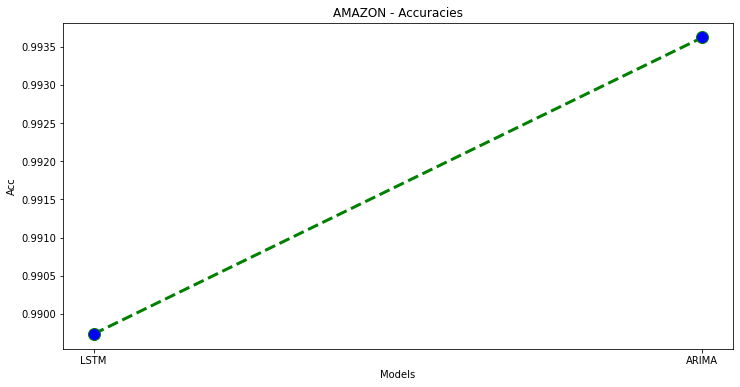

In [108]:
plt.figure(figsize=(12,6))
plt.plot(range(2), Acc, color='green', linestyle='dashed', linewidth = 3, 
          marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("AMAZON - Accuracies")
plt.xticks(range(2), ['LSTM','ARIMA'])
plt.show()

# Google Stock - Accuracies in LSTM & ARIMA Model

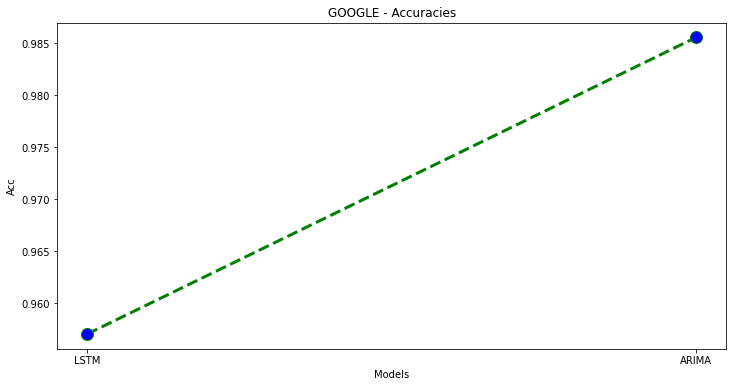

In [109]:
plt.figure(figsize=(12,6))
plt.plot(range(2), Acc_G, color='green', linestyle='dashed', linewidth = 3, 
         marker='o', markerfacecolor='blue', markersize=12) 
plt.ylabel('Acc')
plt.xlabel('Models')
plt.title("GOOGLE - Accuracies")
plt.xticks(range(2), ['LSTM', 'ARIMA'])
plt.show()

**Conclusion**



*  ARIMA model results are appreciable . 
*  As shown for both AMAZON & GOOGLE, ARIMA model offers better prediction accuracy with respect to LSTM and is relatively fast as well to LSTM, in terms of training/fitting time and complexity.
*  ARIMA model predicts GOOGLE to be better Stock than AMAZON

